# Machine Learning Simulation Coursework - Large Margin Classifiers
Maximilian Zebhauser

### Task: 
Coinsider a binary classification problem in which X takes values in $R^d$ and 
$Y \in \{-1, 1\}$. Suppose $P{Y = 1} = 1/2$ and the class-conditional distributions 
are normal with identity covariance matrix but different mean vectors, say 
(-a, 0, 0, . . . , 0) and (a, 0, 0, . . . , 0).

Write a program that generates a training data of n i.i.d. pairs 
$D_{n}=\left\{\left(X_{1}, Y_{1}\right), \ldots,\left(X_{n}, Y_{n}\right)\right\}$ 
of random variables distributed as described above.

Train a linear classifier by performing stochastic gradient-descent minimization 
of the function $f(w)=\mathbf{E} \phi\left(-w^{T} X Y\right)$ for $w \in R^d$ 
where $\phi$ is an increasing convex function.

Estimate the probability of error of the obtained classifier and compare it to 
the optimal linear classifier (which is the Bayes classifier in this case). 
Try different choices of a, n, d and the function $\phi$ (
$\text {including } \phi(x)=(1+x)_{+}, \phi(x)=e^{x}, \phi(x)=\log _{2}\left(1+e^{x}\right)$).

Play with the tuning parameter of the stochastic gradient descent algorithm.

### Theoretical Background: 
Classifier using a convex cost function $\phi$ that can be minimized instead of minimizing the empirical risk. As this is a relaxation, the cost is always higher than the risk both truly ($A(f)=\mathbb{E} \phi(-y f(x))$)and empirically ($A_{n}(f)=\frac{1}{n} \sum_{i=1}^{n} \phi\left(-y f\left(x_{i}\right)\right)$). Additionally, we generalize the function $f(x)$ and receive the classification rule: 
$$ g_{f}(x)=\left\{\begin{array}{ll}{1,} & {\text { if } f(x)>0} \\ {-1,} & {\text { otherwise }}\end{array}\right. $$
Support vector machines (\textbf{SVM}) minimize the Hinge Loss. 
Additionally, a margin loss can be introduced, which add cost even if they are 
correctly classified but lie within the margin. 
Voting schemes and averaging is used by many classifiers. Methods like bagging, 
boosting and random forests use weighted averages of basic classification rules. 
Although these functions can be very complicated, the margin and the VC-dimension 
of the base class matter. One example of these algorithms is called ADABOOST.

### Answer: 
We know the Bayes classifier has the following decision rule:
$$ g^{*}(x^{(1)})=\left\{\begin{array}{ll}{ 1} & {\text { if }  x^{(1)} > 0} \\ {-1} & {\text { if } x^{(1)} \leq 0}  \end{array}\right. $$
Intuitively the data gets separable with a high probability for large $a$. 
Then, we can rewrite the two distributions as $Y=-1$ if 
$x^{(1)} \sim N\left( - a , 1\right) $ and $Y=1$ if $x^{(1)} 
\sim N\left( a, 1\right)$. Because the PMF is symmetric and the mean of 
the two distributions have the same distance from zero, both tails cover 
the same area above and below respectively. In this case, we derive the 
Bayes Risk $R ^ { * }$ as follows: 
$$ \begin{aligned} R ^ { * } = R \left( g ^ { * } \right) & = P ( g ( x ) = 1 | Y = -1 ) \cdot q _ { 0 } + P ( g ( x ) = -1 | Y = 1 ) \cdot q _ { 1 } \\ & = \frac{1}{2} \left( P ( g ( x ) = 1 | Y = -1 ) + P ( g ( x ) = -1 | Y = 1 ) \right)\\ & = \frac{1}{2} \left( P ( x \geq 0 | Y = -1) + P ( x \leq 0 | Y = 1 ) \right)\\ & = P ( x \leq 0 | Y = 1 ) = \Phi(0-a) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{-a} e^{-t^{2} / 2} d t \\& \implies \lim_{a \to \infty} R^* = 0 \end{aligned}$$

We can clearly see from the plots that the three different loss functions 
(hinge, exponential and logistic loss) behave similarly. In summary, higher 
dimensions and smaller sample sizes have a negative impact on the empirical 
risk compared to the benchmark.

In all settings the empirical risk is very close to the Bayes risk, which is 
the optimal risk for the linear classifier. One remark about the learning rate 
(hyperparameter of the SDG) in the case of the exponential loss function. A high 
learning rate causes convergence problems as the minimum of the function cannot be 
reached and the weights don't stop growing: $\lim_{w \to \infty} \phi(w) = 
\lim_{w \to \infty} e^{-w^{T} X Y} = 1$. Empirics show that in our settings 
reliable results can be obtained for $\eta \leq 0.1$.
### Supporting Code & Plots:

In [1]:
require(doParallel)
require(foreach)
require(RColorBrewer)
require(MASS)

sim_data <- function(a, d, n){
    Y <- sign(runif(n,-1,1))
    X_1 <- ifelse(Y > 0, rnorm(n, a), rnorm(n,-a))
    X_d <- mvrnorm(n, rep(0,(d-1)), diag((d-1)))
    cbind(Y, X_1, X_d)
}
grad_phi1 <- function(w, x, y){
    if(w %*% x * y <= 1) {(- x * y)} else 0 
}
grad_phi2 <- function(w, x, y){
    der <- exp(-(y * (w %*% x)))
    der <- ifelse(der == Inf, 0, der)
    #der <- ifelse(is.na(der), 0, der)
    (-(x * y)) * as.vector(der)
}
grad_phi3 <- function(w, x, y){
    as.vector(-(x * y)) * (1 / (log(2) + log(2) * as.vector(exp((y * (w %*% x)) ))))
}
stoch_desc <- function(dat, grads, eta, max_iter=NULL){
    max_iter <- ifelse(is.null(max_iter), nrow(dat), max_iter)
    w <- rbind(rep(0,(ncol(dat)-1)), diag(0, ncol = (ncol(dat)-1), nrow = max_iter))
    usage <- sample(1:nrow(dat), max_iter, replace = T)
    for(t in 2:(max_iter+1)){
        Y <- dat[usage[(t-1)],1]; X <- dat[usage[(t-1)],2:ncol(dat)]
        v <- grads(w[(t-1),], X, Y)
        w[t,] <- w[(t-1),] - eta * v
    }
    colMeans(w[2:(max_iter+1),])
}

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: RColorBrewer
Loading required package: MASS


[1] 2.0118163 0.2806519

[1] 3.1580059 0.1263166

[1] 3.40940643 0.08681139

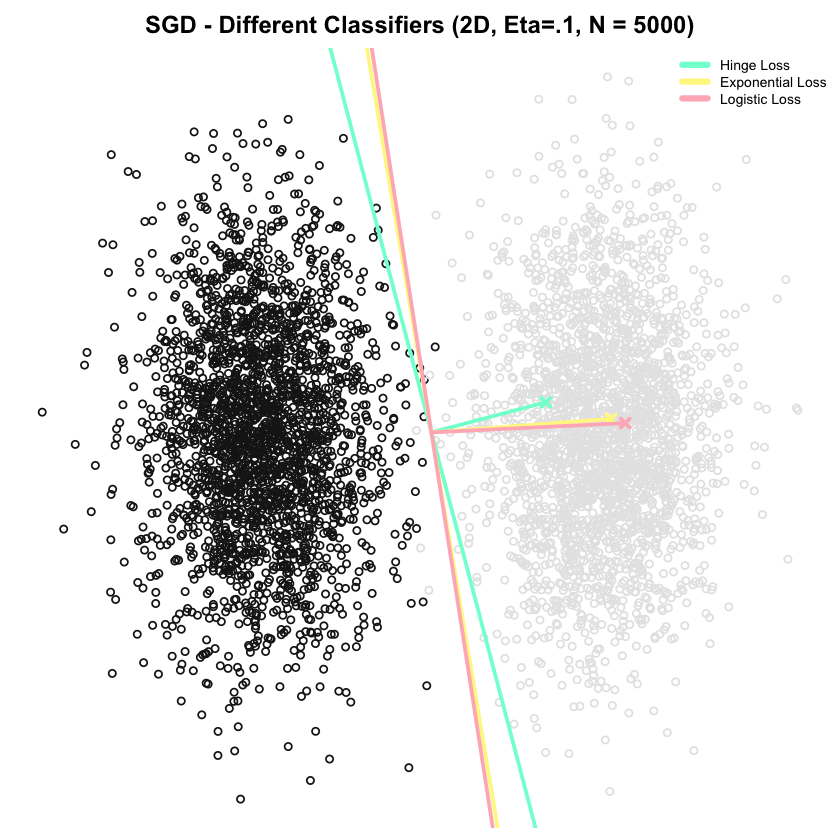

In [2]:
# Data ====
set.seed(123)
see <- sim_data(3,2,5000)
par(mar=c(.5,.5,2,.5))
losses <- c("Hinge Loss", "Exponential Loss", "Logistic Loss")
cols <- c("aquamarine","khaki1","lightpink")
plot(see[,2:3], col=ifelse(see[,1] > 0, "grey90", "grey10"),lwd=1.4,cex=.8, xaxt='n', yaxt='n', 
     ylab="", xlab="",axes=FALSE, main="SGD - Different Classifiers (2D, Eta=.1, N = 5000)")
legend("topright", losses, col = cols, lwd = 5, cex = .7, bty="n", bg = "white")

# Hinge Loss ====
(desc <- stoch_desc(dat = see, grads = grad_phi1, eta = .1))
points(x= desc[1], y=desc[2], col=cols[1],pch=4,lwd=3)
segments(x0=0,y0=0,x1= desc[1],y1=desc[2],col=cols[1],lwd=3)
abline(c(0,0),c(-desc[1],desc[2]),col=cols[1],lwd=3)


# Exponential Loss ====
(desc <- stoch_desc(dat = see, grads = grad_phi2, eta = .1))
points(x= desc[1], y=desc[2], col=cols[2],pch=4,lwd=3)
segments(x0=0,y0=0,x1= desc[1],y1=desc[2],col=cols[2],lwd=3)
abline(c(0,0),c(-desc[1],desc[2]),col=cols[2],lwd=3)

# Logarithmic loss ====
(desc <- stoch_desc(dat = see, grads = grad_phi3, eta = .1))
points(x= desc[1], y=desc[2], col=cols[3],pch=4,lwd=3)
segments(x0=0,y0=0,x1= desc[1],y1=desc[2],col=cols[3],lwd=3)
abline(c(0,0),c(-desc[1],desc[2]),col=cols[3],lwd=3)

# Cleanup ====
par(mar=c(5.1, 4.1, 4.1, 2.1))
rm(see,desc,losses, cols)

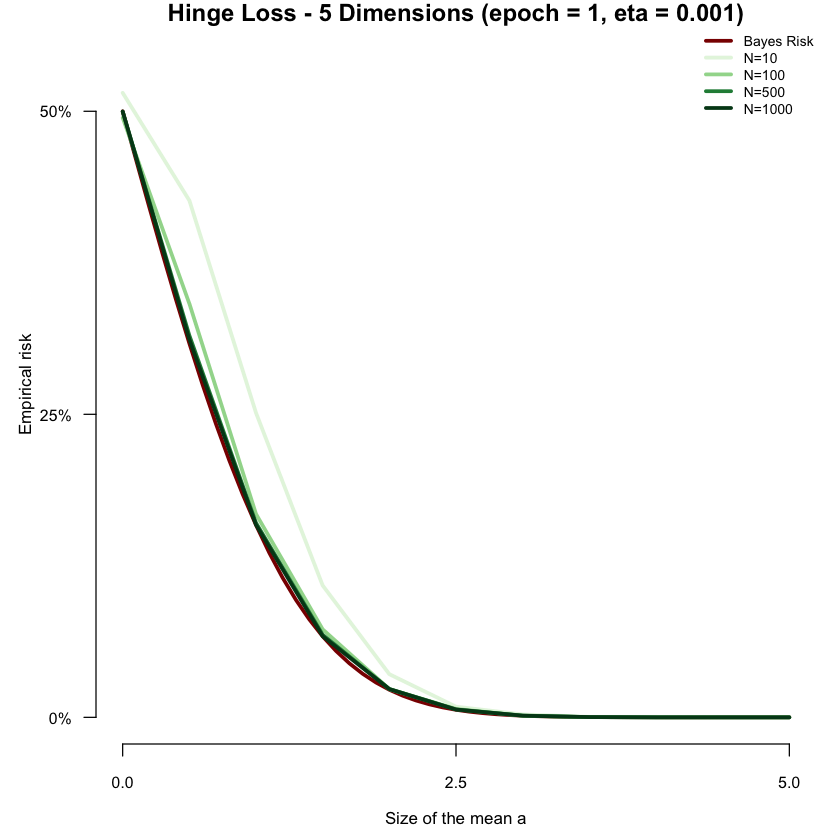

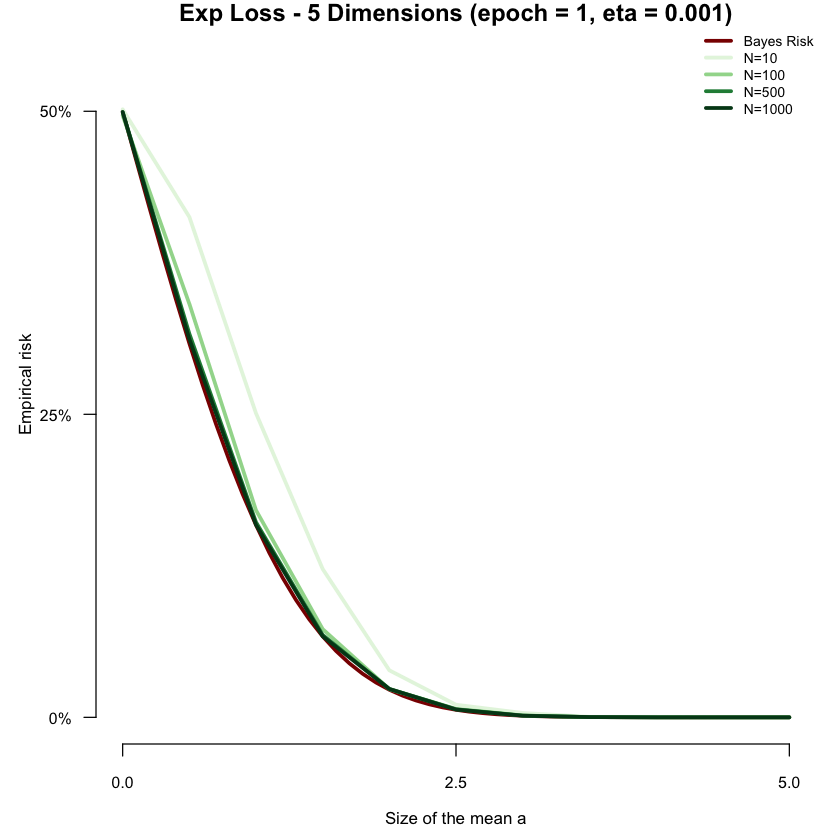

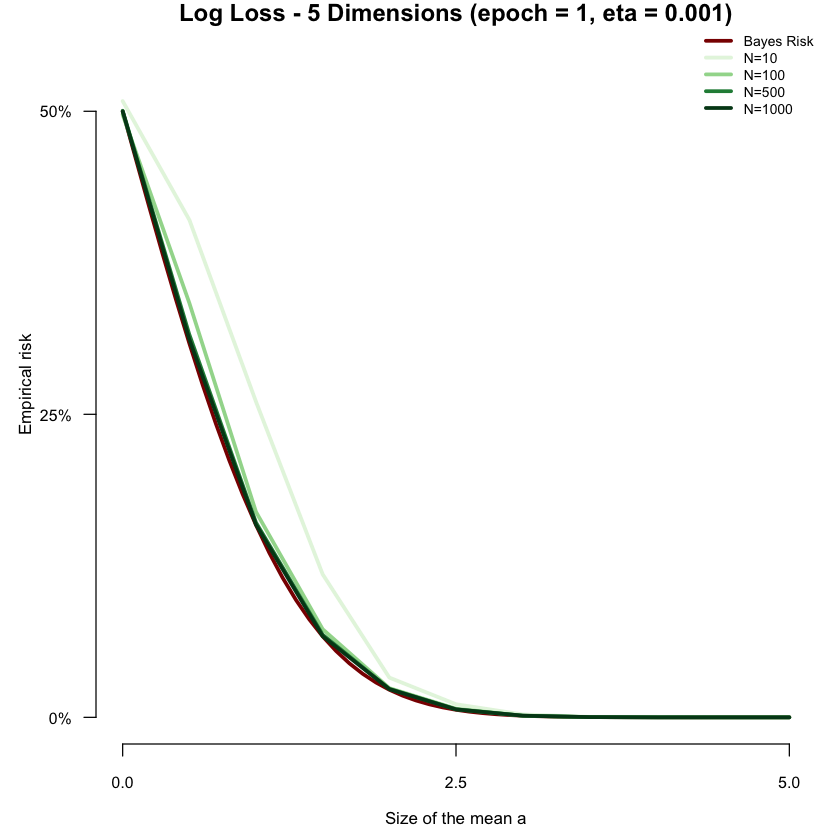

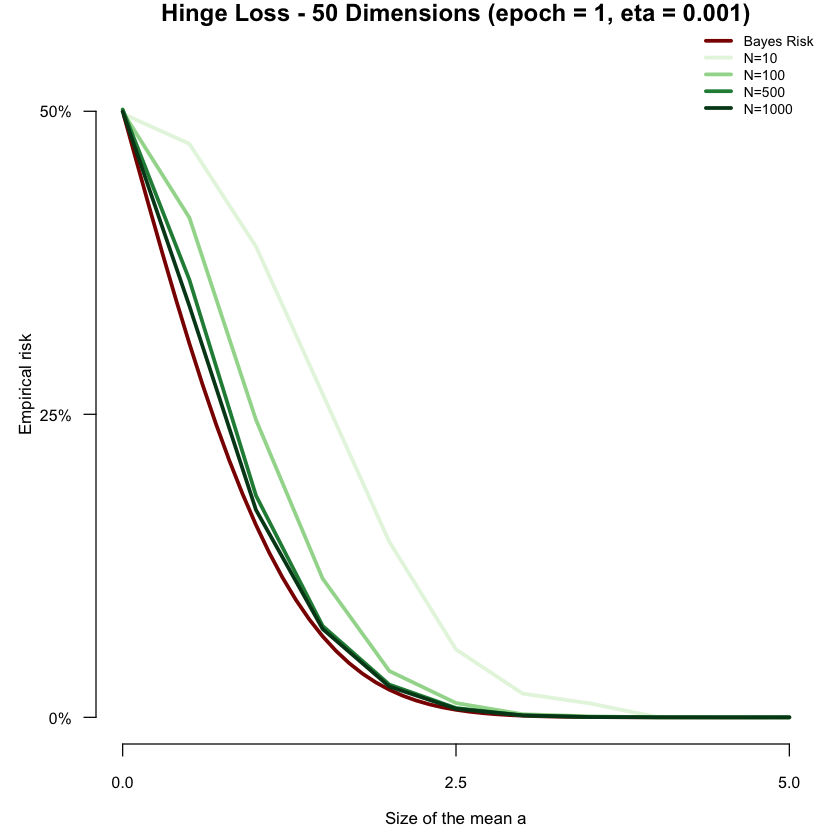

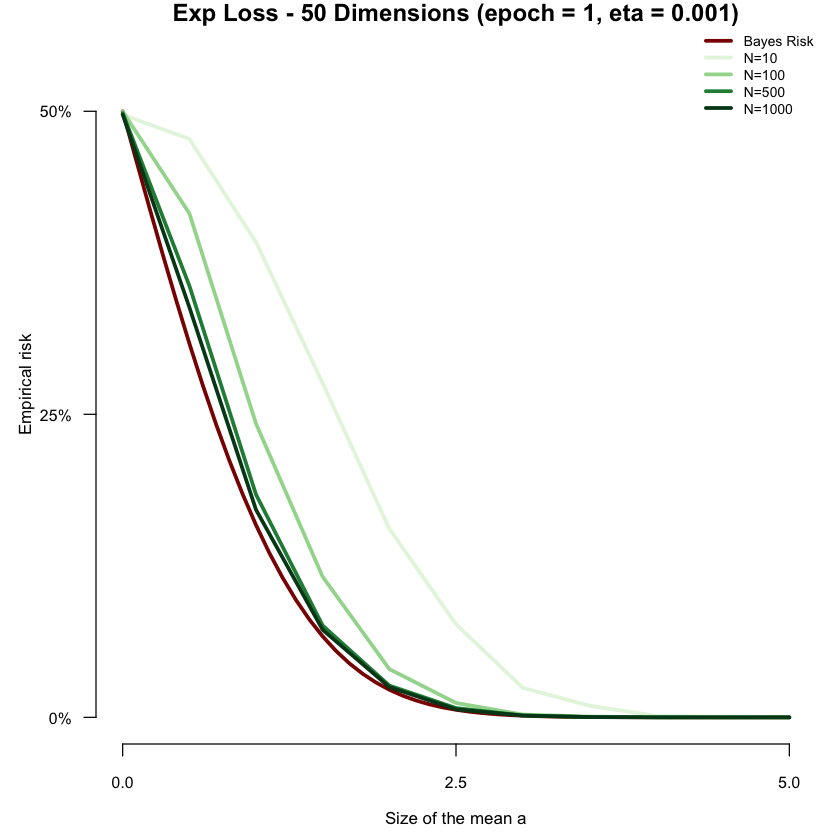

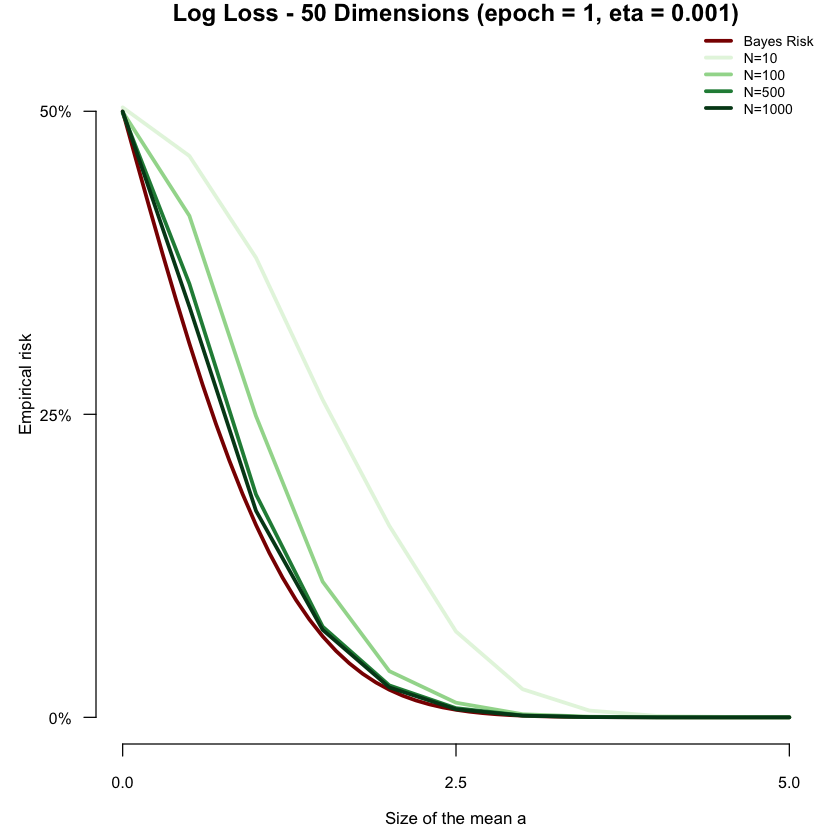

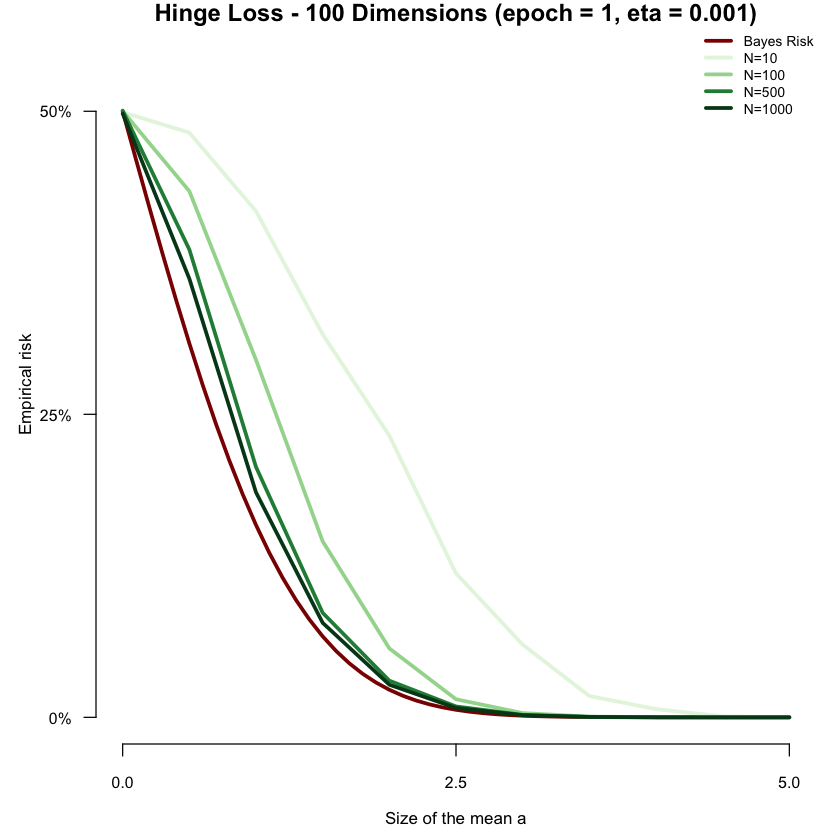

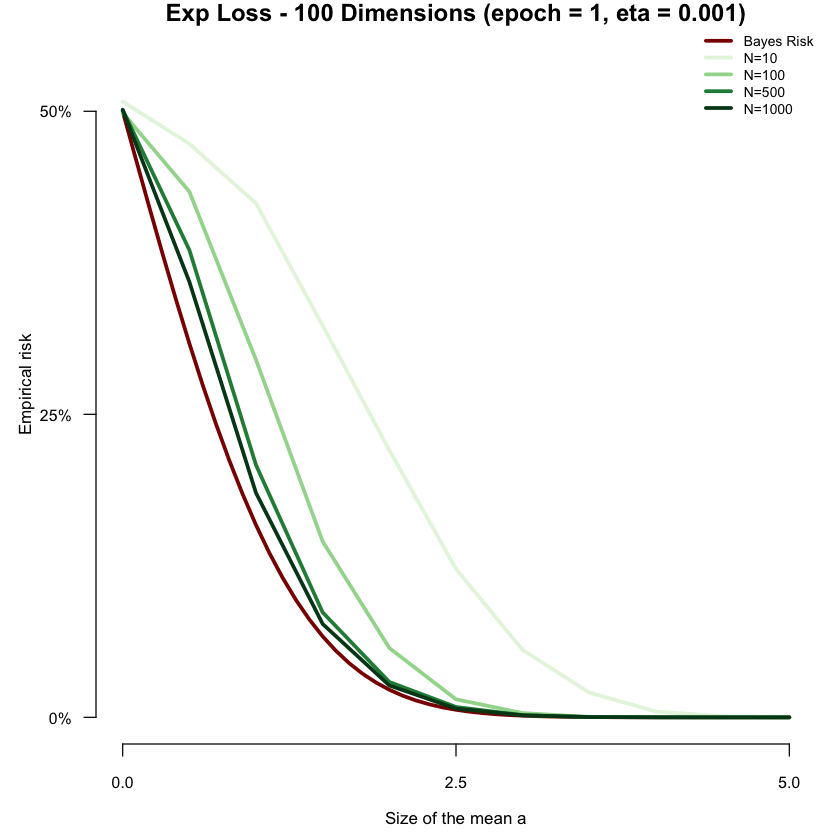

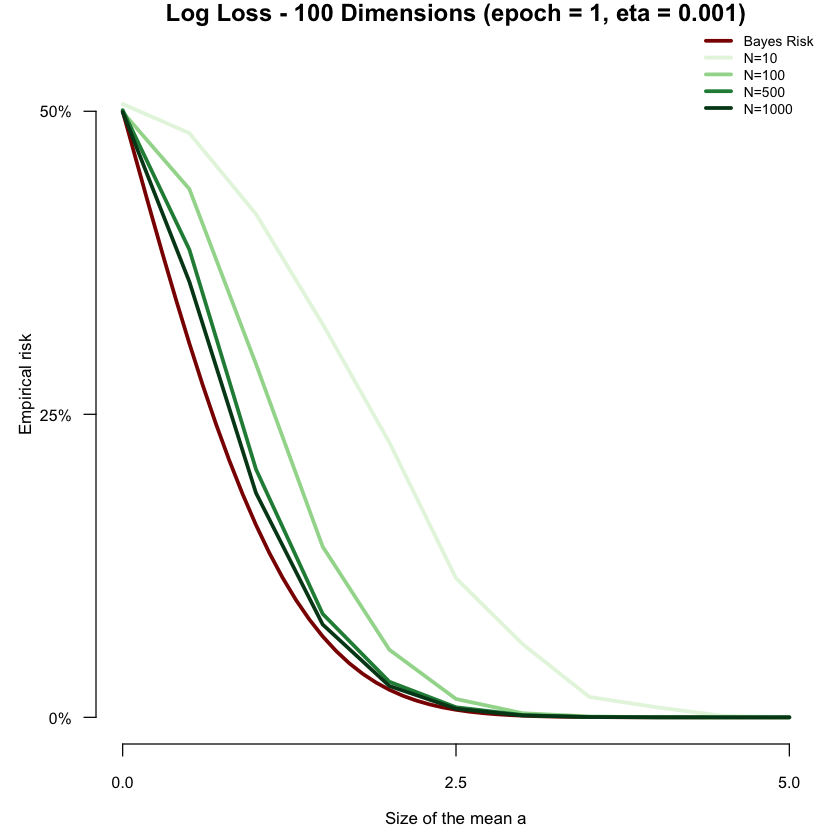

In [3]:
# Analysis ====
N_1 <- c(10,100,500,1000)
M_1 <- seq(0,5,.5)
D_1 <- c(5,50,100)
mypalette <- brewer.pal(9,"Greens")[c(2,4,7,9)]
cols <- c("darkred","aquamarine","khaki1","lightpink")
losses <- c("Hinge","Exp","Log")
mus <- seq(min(M_1),max(M_1),.1)
bayes <- pnorm(0, mean = mus)
list_risk <- list()
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)
for(D_iter in 1:length(D_1)){
    for(N_iter in 1:length(N_1)){
        list_risk[[N_iter]] <- matrix(rep(0,length(M_1)*3), ncol=3)
        for(M_iter in 1:length(M_1)){
            zwischen <- foreach(i = 1:250,.combine = rbind, .packages = "MASS") %dopar% {
                train_data <- sim_data(M_1[M_iter],D_1[D_iter],N_1[N_iter])
                test_data  <- sim_data(M_1[M_iter],D_1[D_iter],(N_1[N_iter]))
                hinge_w    <- stoch_desc(train_data , grads = grad_phi1, eta = .001)
                exp_w      <- stoch_desc(train_data , grads = grad_phi2, eta = .001)
                log_w      <- stoch_desc(train_data , grads = grad_phi3, eta = .001)
                hinge      <- mean(apply(test_data, 1, function(C) C[1] * (hinge_w %*% C[2:length(C)]) <= 0))
                exp        <- mean(apply(test_data, 1, function(C) C[1] * (exp_w %*% C[2:length(C)]) <= 0))
                log        <- mean(apply(test_data, 1, function(C) C[1] * (log_w %*% C[2:length(C)]) <= 0))
                c(hinge, exp, log)
            }
            list_risk[[N_iter]][M_iter,] <- colMeans(zwischen, na.rm = T)
        }
        colnames(list_risk[[N_iter]]) <- losses
        rownames(list_risk[[N_iter]]) <- paste0("a_",M_1)
    }
    names(list_risk) <- paste0("N_",N_1)
    for(tl in 1:length(losses)){
        par(oma=c(0,0,0,0), mar=c(4, 4, 1, 1), cex.axis=.8, cex.lab=.85, cex.main=1.2, mgp=c(2.5,1,0))
        plot(mus, bayes, lwd=3, col=cols[1],type="l", ylim= c(0,.55), ylab="Empirical risk",xlab="Size of the mean a",
             main=paste0(losses[tl]," Loss - ", D_1[D_iter]," Dimensions ","(epoch = 1, eta = 0.001)"), 
             yaxt = 'n', xaxt = 'n', bty="n")
        axis(1, at=c(0,2.5,5));axis(2, at=c(0,.25,.5), las =2, labels = c("0%","25%","50%"))
        for(i in 1:length(N_1)) lines(M_1,list_risk[[i]][,tl], lwd=3, col=mypalette[i])
        legend("topright", c("Bayes Risk",paste0("N=",unlist(N_1))), col = c("darkred",mypalette), 
               lwd = 3, cex = .7, bty="n")
    }
}
stopCluster(cl)